In [1]:
import tensorflow as tf
import numpy as np


def image_pair_downsampler(images):
    # Create kernels for diagonal averaging
    filter_1 = tf.constant([[1, 0], [0, 1]], dtype=tf.float32)  # Top-left and bottom-right
    filter_2 = tf.constant([[0, 1], [1, 0]], dtype=tf.float32)  # Top-right and bottom-left
    filter_1 = filter_1[:, :, None, None] / 2.0  # Shape: (2, 2, 1, 1)
    filter_2 = filter_2[:, :, None, None] / 2.0  # Shape: (2, 2, 1, 1)

    # Adjust for image channels
    channels = images.shape[-1]
    filter_1 = tf.tile(filter_1, [1, 1, channels, 1])
    filter_2 = tf.tile(filter_2, [1, 1, channels, 1])

    # Apply filters to downsample images
    stride = [1, 2, 2, 1]  # Downsampling by 2
    downsampled_1 = tf.nn.depthwise_conv2d(images, filter_1, strides=stride, padding='SAME')
    downsampled_2 = tf.nn.depthwise_conv2d(images, filter_2, strides=stride, padding='SAME')

    return downsampled_1, downsampled_2


In [2]:
# Check TensorFlow version
print(tf.__version__)

# List physical devices to verify GPU is detected
print(tf.config.list_physical_devices())

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import cv2
def load_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = np.asarray(image, dtype=np.float32) / 255.0  # Convert to float32 and normalize
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [3]:
image_path =  'YOUR IMAGE PATH'
image = load_image(image_path)
image.shape
image.shape

(1, 512, 512, 1)

In [232]:
downsampled_1, downsampled_2 = image_pair_downsampler(image)
downsampled_1.shape, downsampled_2.shape

(TensorShape([1, 256, 256, 1]), TensorShape([1, 256, 256, 1]))

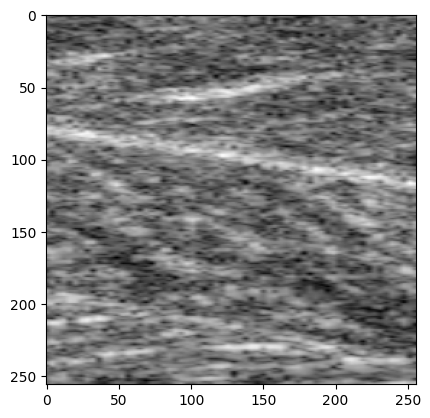

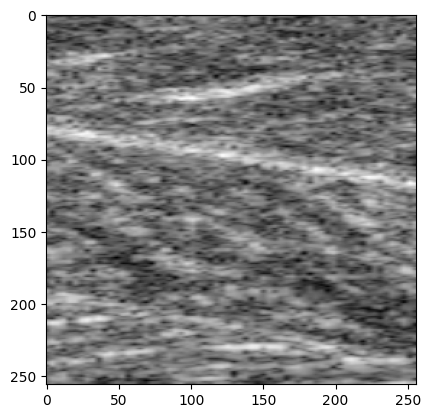

In [238]:
# Show the downsampled images
import matplotlib.pyplot as plt
plt.imshow(downsampled_1[0, :, :, 0], cmap='gray')
plt.show()

plt.imshow(downsampled_2[0, :, :, 0], cmap='gray')
plt.show()

In [8]:
class SimpleImageToImageModel(tf.keras.Model):
    def __init__(self):
        super(SimpleImageToImageModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')  # Assuming grayscale output
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [9]:
def symmetric_consistency_loss(y, y_pred, model):
    # Downsample the original and predicted images
    d1_y, d2_y = image_pair_downsampler(y)
    d1_y_pred, d2_y_pred = image_pair_downsampler(y_pred)
    
    # Apply the model to downsampled versions of the original image
    f_d1_y = model(d1_y)
    f_d2_y = model(d2_y)
    
    # Calculate the loss based on the symmetric consistency equation provided
    # Note: The formula's exact implementation might vary based on its full description.
    # The following attempts to mirror the structure you've described, assuming it aims to minimize
    # the difference between downsampled predictions and the model's output given downsampled inputs.
    loss_1 = tf.reduce_mean(tf.square(d1_y_pred - f_d1_y))
    loss_2 = tf.reduce_mean(tf.square(d2_y_pred - f_d2_y))

    # Assuming a symmetric loss combines these two components equally
    total_loss = 0.5 * (loss_1 + loss_2)
    
    return total_loss


In [10]:
import os

# Get all folders in data_path
def get_folders(data_path):
    return [os.path.join(data_path,f) for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Get all subfolders in data_path
def get_subfolders(data_path):
    return [os.path.join(data_path,f) for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Get all files in data_path
def get_files(data_path):
    # [os.path.join(data_path,f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.png')]
    all_files = []
    for f in os.listdir(data_path):
        if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.png'):
            all_files.append(os.path.join(data_path, f))

    # # Get 10 equispaced files
    # file_indexes = np.linspace(0, len(all_files)-1, 10, dtype=int)
    # selected_files = [all_files[i] for i in file_indexes]
    return all_files

In [4]:
data_path = '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data'
folders = get_folders(data_path)
files = []
for folder in folders:
    subfolders = get_subfolders(folder)
    for subfolder in subfolders:
        files.extend(get_files(subfolder))

In [14]:
import tensorflow as tf

# Assuming 'file_paths' is your existing array of image file paths
file_paths_dataset = tf.data.Dataset.from_tensor_slices(files)

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Use decode_png if your images are PNG
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize images to [0,1]
    img = tf.image.resize(img, [512, 512])  # Ensure images are resized to 512x512
    return img

# Map the file paths to the actual image processing
dataset = file_paths_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch to improve performance
batch_size = 10  # Adjust based on your GPU's memory
dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
import tensorflow as tf

# Assuming 'file_paths' is your existing array of image file paths
file_paths_dataset = tf.data.Dataset.from_tensor_slices(files)

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Use decode_png if your images are PNG
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize images to [0,1]
    img = tf.image.resize(img, [512, 512])  # Ensure images are resized to 512x512
    return img

# Randomly shuffle the dataset
# Note: buffer_size should be greater than the number of elements in the dataset for perfect shuffling
# But it can be set to a smaller value if you're constrained by memory
file_paths_dataset = file_paths_dataset.shuffle(buffer_size=50000)

# Take a smaller subset for training
# For example, to use only 1000 samples from your dataset
subset_size = 10000
file_paths_dataset = file_paths_dataset.take(subset_size)

# Map the file paths to the actual image processing
dataset = file_paths_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch to improve performance
batch_size = 10  # Adjust based on your GPU's memory
dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [369]:
# What is the length of the file_paths_dataset?
print(len(file_paths_dataset))

10000


In [15]:
model = SimpleImageToImageModel()

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

@tf.function
def train_step(images, model, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = symmetric_consistency_loss(images, predictions, model)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    progbar = tf.keras.utils.Progbar(len(dataset))

    # Iterate over the batches of the dataset.
    for step, images in enumerate(dataset):
        loss = train_step(images, model, optimizer)
        progbar.update(step + 1, values=[("loss", loss)], finalize=False)

    progbar.update(len(dataset), finalize=True)


Epoch 1/10


2024-04-06 01:16:21.365309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 407s 407ms/step - loss: 6.7465e-09
Epoch 2/10
1000/1000 [==============================] - 409s 409ms/step - loss: 2.5576e-09
Epoch 3/10
1000/1000 [==============================] - 404s 404ms/step - loss: 1.4527e-09
Epoch 4/10
1000/1000 [==============================] - 405s 406ms/step - loss: 1.0062e-09
Epoch 5/10
1000/1000 [==============================] - 400s 400ms/step - loss: 7.8495e-10
Epoch 6/10
1000/1000 [==============================] - 402s 402ms/step - loss: 6.5927e-10
Epoch 7/10
1000/1000 [==============================] - 403s 404ms/step - loss: 5.6307e-10
Epoch 8/10
1000/1000 [==============================] - 404s 405ms/step - loss: 5.0074e-10
Epoch 9/10
1000/1000 [==============================] - 422s 421ms/step - loss: 4.4999e-10
Epoch 10/10
1000/1000 [==============================] - 415s 415ms/step - loss: 4.1098e-10


In [20]:
model.save('./saved_model_1')

INFO:tensorflow:Assets written to: ./saved_model_1/assets


INFO:tensorflow:Assets written to: ./saved_model_1/assets


In [242]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Use decode_png for PNG images
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize the image to [0, 1]
    img = tf.image.resize(img, [512, 512])  # Resize the image to 512x512
    img = img[tf.newaxis, ...]  # Add a batch dimension
    return img

# Example usage


In [4]:
model = tf.keras.models.load_model('./saved_model_1')

2024-04-12 04:35:39.401804: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-12 04:35:39.401841: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-12 04:35:39.401849: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-12 04:35:39.401924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-12 04:35:39.401967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
predictions = model(image, training=False)
predictions.shape

TensorShape([1, 512, 512, 1])

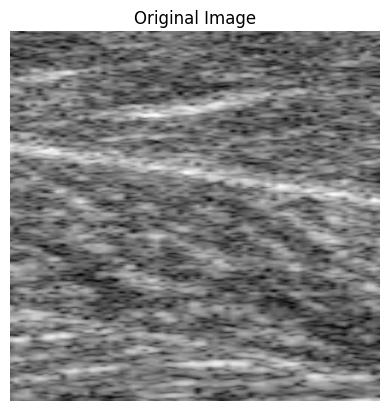

In [7]:
import matplotlib.pyplot as plt
plt.imshow(image[0, ..., 0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

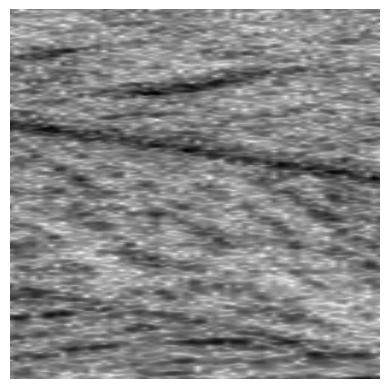

In [8]:
# show the image
import matplotlib.pyplot as plt
plt.imshow(predictions[0, ..., 0], cmap='gray')
plt.axis('off')  # Turn off axis numbers
plt.show()

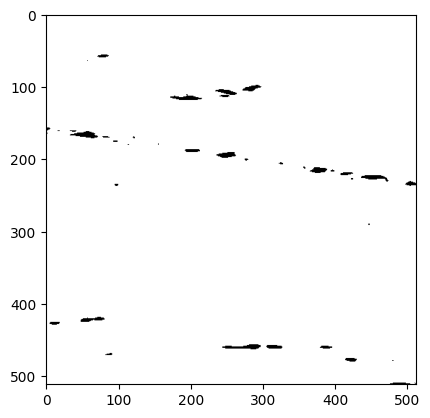

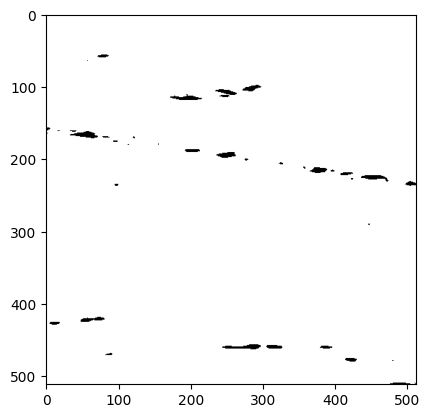

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from preprocessors.isolate_intensity import isolate_intensity
from preprocessors.edge_detection import edge_detection

# Assuming 'predictions' is a tensor and you are extracting the first element
frame = predictions[0, ..., 0].numpy()
plt.imshow(frame_scaled, cmap='gray')
plt.show()
# For each pixel, if the intensity is below 255/2, set it 255/2 + (255/2 - intensity)
# frame = cv2.bitwise_not(frame)
# Assuming 'isolate_intensity' function properly isolates intensity if you have defined it elsewhere
frame = isolate_intensity(frame_scaled, 'avg_min_intensity')

plt.imshow(frame, cmap='gray')
plt.show()

127 0


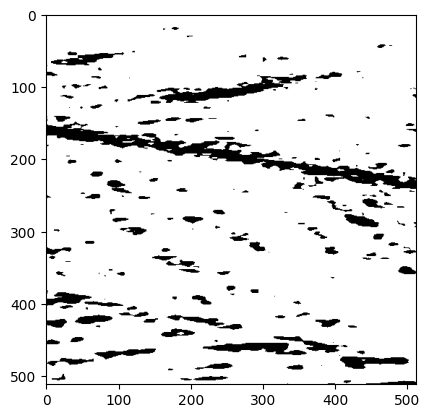

In [12]:
frame_clipped = np.clip(frame, 0, 1)
frame_scaled = (frame_clipped * 255).astype(np.uint8)


max_intensity = np.max(frame_scaled)
min_intensity = np.min(frame_scaled)
print(max_intensity, min_intensity)

plt.imshow(frame_scaled, cmap='gray')

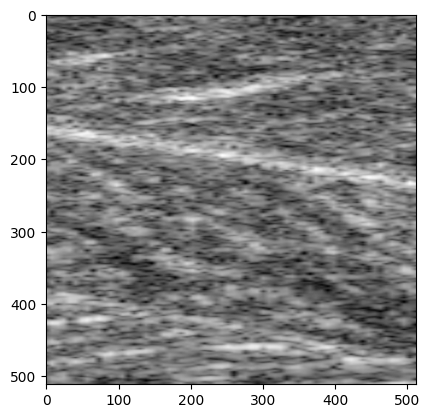

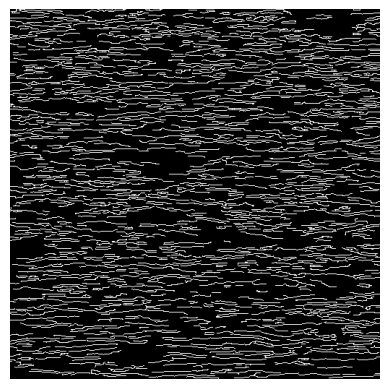

In [13]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
# plt.axis('off')
plt.show()

edges_og = edge_detection(img)
plt.imshow(edges_og, cmap='gray')
plt.axis('off')
plt.show()

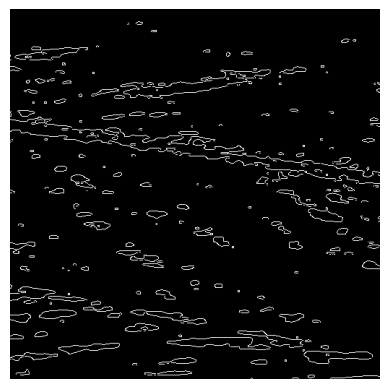

In [14]:
edges = edge_detection(frame_scaled)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

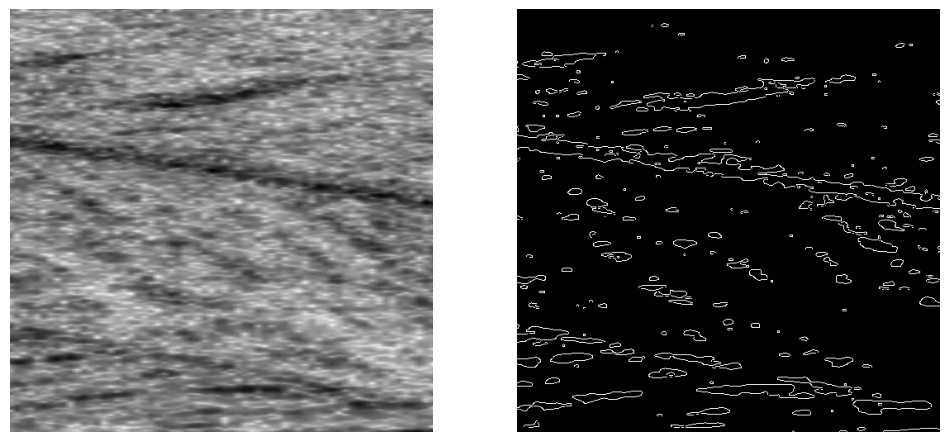

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(predictions[0,...,0], cmap='gray')
axs[0].axis('off')
axs[1].imshow(edges, cmap='gray')
axs[1].axis('off')
plt.show()

In [20]:
from preprocessors.hough_transform import hough_transform

# Assuming 'edges' is the output of your edge detection function
edges = cv2.flip(edges, 1)
plt.imshow(edges, cmap='gray')

0.50086516 0.49750525


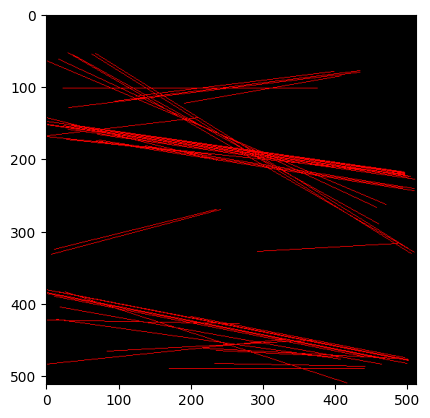

In [29]:
min_line_length = edges.shape[1]//3
max_line_gap = edges.shape[1]//5

lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=min_line_length, maxLineGap=max_line_gap)
lines2 = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=min_line_length, maxLineGap=max_line_gap)

# Draw the lines on a copy of the original image
predictions = predictions[0,...,0].numpy()
max_intensity = np.max(predictions)
min_intensity = np.min(predictions)
print(max_intensity, min_intensity)
aponeuroses = predictions.copy().astype(np.uint8)
# Convert to 3 channels
aponeuroses = cv2.cvtColor(aponeuroses, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses, (x1, y1), (x2, y2), (255, 0, 0), 1)

plt.imshow(aponeuroses, cmap='gray')

In [259]:
import math
def filter_lines_by_angle(lines, angle_min, angle_max):
    filtered_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = math.atan2(y2 - y1, x2 - x1) * 180.0 / np.pi
            if angle_min <= angle <= angle_max:
                filtered_lines.append(line)
    return filtered_lines

(-0.5, 511.5, 511.5, -0.5)

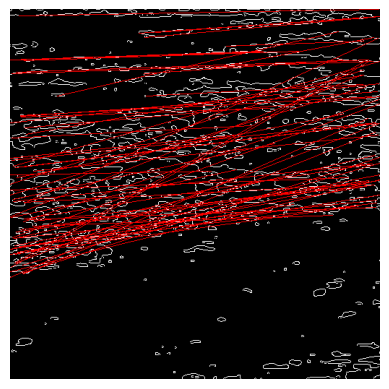

In [260]:
filtered_lines = filter_lines_by_angle(lines, -30, -1)

# show the filtered lines on a copy of the original image
aponeuroses_filtered = edges.copy().astype('uint8')
# Convert to 3 channels
aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (255, 0, 0), 1)

plt.imshow(aponeuroses_filtered, cmap='gray')
plt.axis('off')

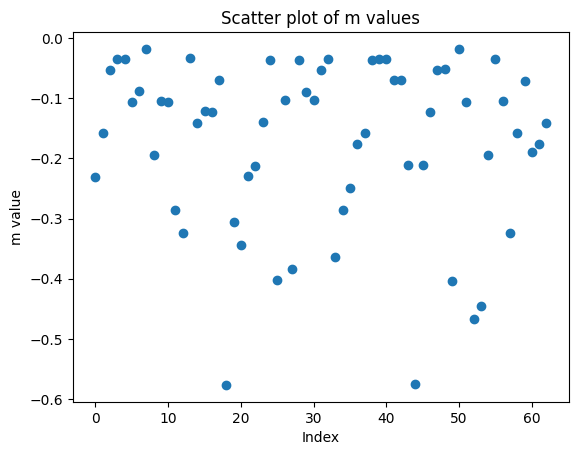

In [261]:
def calculate_slope_intercept(lines):
    m_values = []
    c_values = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 - x1 != 0:  # Avoid division by zero
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1
                m_values.append(m)
                c_values.append(c)
            else:  # Vertical line, slope is infinite, so we skip or handle differently
                pass
    return m_values, c_values

def plot_c_values(c_values):
    # Assuming each c value is unique and plotting against a dummy X-axis
    plt.scatter(range(len(c_values)), c_values)
    plt.title('Scatter plot of m values')
    plt.xlabel('Index')
    plt.ylabel('m value')
    plt.show()

# Example usage
m_values, c_values = calculate_slope_intercept(filtered_lines)
plot_c_values(m_values)

In [262]:
intercept = np.median(c_values)
slope = np.median(m_values)
intercept, slope

(257.0, -0.12244897959183673)

In [263]:
def slope_to_angle(slope):
    return math.atan(slope) * 180.0 / np.pi

In [264]:
new_slope = slope_to_angle(slope)
# Round to nearest int (up or down)
print(new_slope)
new_slope = int(new_slope - 0.5)
new_slope

-6.981057406829795


-7

(-0.5, 511.5, 511.5, -0.5)

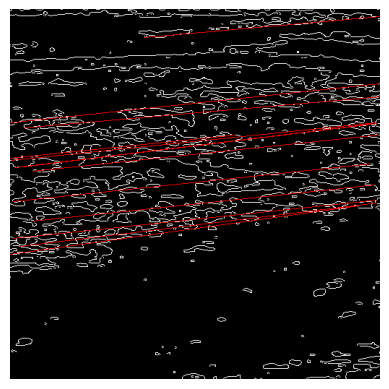

In [269]:
filtered_lines = filter_lines_by_angle(filtered_lines, -8, -4)

# show the filtered lines on a copy of the original image
aponeuroses_filtered = edges.copy().astype('uint8')
# Convert to 3 channels
aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (255, 0, 0), 1)

plt.imshow(aponeuroses_filtered, cmap='gray')
plt.axis('off')

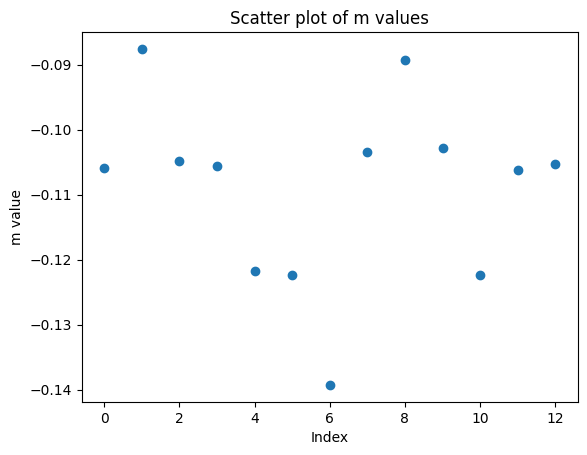

In [270]:
m_values, c_values = calculate_slope_intercept(filtered_lines)
plot_c_values(m_values)

In [271]:
intercept = np.median(c_values)
slope = np.median(m_values)
intercept, slope

(220.20408163265307, -0.10557768924302789)

In [272]:
new_slope = slope_to_angle(slope)
# Round to nearest int (up or down)
print(new_slope)
new_slope = int(new_slope - 0.5)
new_slope

-6.026829198161768


-6

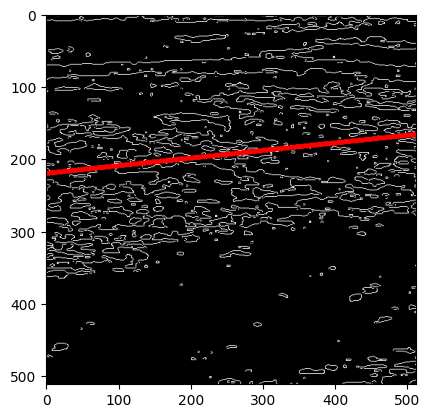

In [273]:
# Draw a line with the calculated slope and intercept on a copy of the original image
aponeuroses_line = edges.copy().astype('uint8')
# aponeuroses_line = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
aponeuroses_line = cv2.cvtColor(aponeuroses_line, cv2.COLOR_GRAY2BGR)
width = aponeuroses_line.shape[1]

# Draw the line
x1 = 0
y1 = int(intercept)
x2 = width
y2 = int(slope * x2 + intercept)

# Draw two more lines to better visualize the aponeuroses
x3 = 0
y3 = int(intercept - 1)
x4 = width
y4 = int(slope * x4 + intercept - 1)

x5 = 0
y5 = int(intercept + 1)
x6 = width
y6 = int(slope * x6 + intercept + 1)

cv2.line(aponeuroses_line, (x1, y1), (x2, y2), (255, 0, 0), 5)
# cv2.line(aponeuroses_line, (x3, y3), (x4, y4), (255, 0, 0), 2)
# cv2.line(aponeuroses_line, (x5, y5), (x6, y6), (255, 0, 0), 2)

plt.imshow(aponeuroses_line, cmap='gray')
# plt.axis('off')

In [190]:
# Filter to get only lines that are above a certain line
def filter_lines_by_y(lines, y_min):
    filtered_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if y1 < y_min and y2 < y_min:
                filtered_lines.append(line)
    return filtered_lines

In [191]:
filtered_lines = []
filtered_lines = filter_lines_by_y(lines, min(y1, y2))

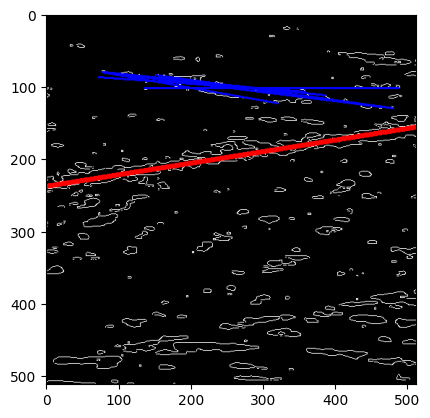

In [192]:
# show the filtered lines on a copy of the original image
aponeuroses_filtered = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
# aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(aponeuroses_filtered, cmap='gray')

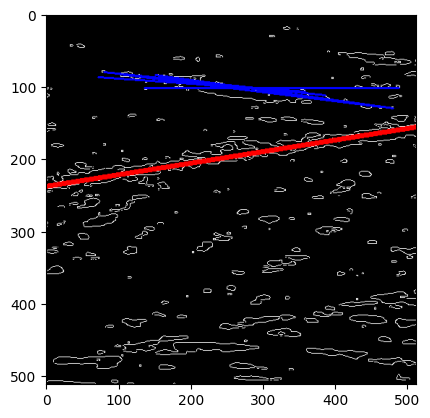

In [193]:
filtered_lines = filter_lines_by_angle(filtered_lines, -10, 10)

# show the filtered lines on a copy of the original image
aponeuroses_filtered = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
# aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(aponeuroses_filtered, cmap='gray')

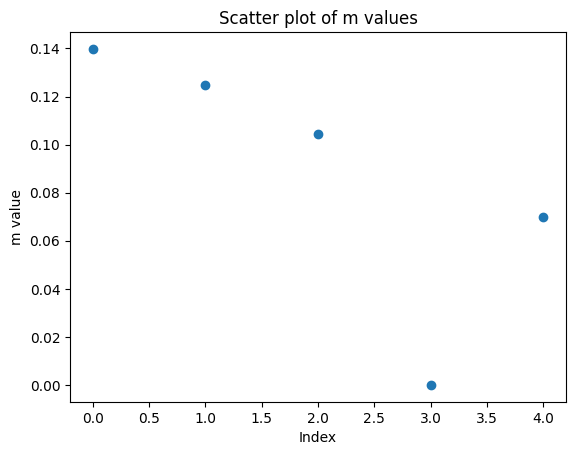

In [194]:
m_values, c_values = calculate_slope_intercept(filtered_lines)
plot_c_values(m_values)

In [195]:
intercept = np.median(c_values)
slope = np.median(m_values)
intercept, slope

(71.63398692810458, 0.10457516339869281)

In [196]:
new_slope = slope_to_angle(slope)
int(new_slope)

5

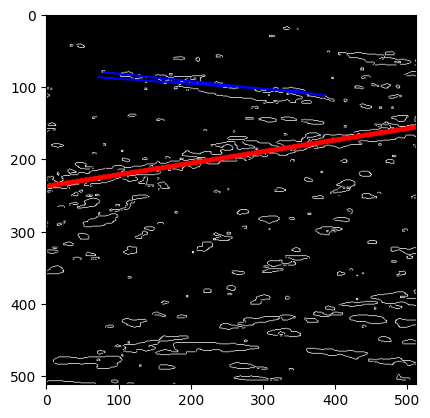

In [197]:
filtered_lines = filter_lines_by_angle(filtered_lines, 3, 7)

# show the filtered lines on a copy of the original image
aponeuroses_filtered = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
# aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(aponeuroses_filtered, cmap='gray')

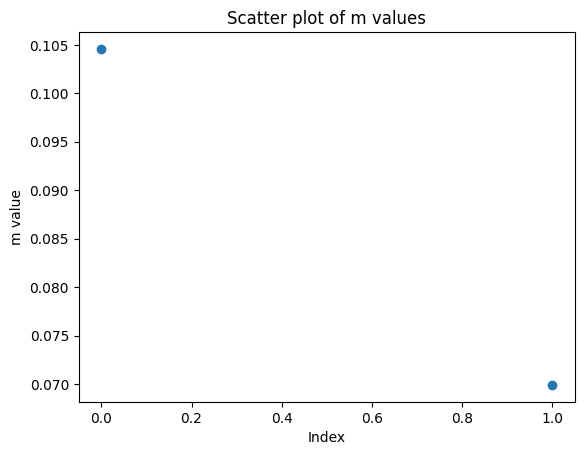

In [198]:
m_values, c_values = calculate_slope_intercept(filtered_lines)
plot_c_values(m_values)

In [199]:
intercept = np.median(c_values)
slope = np.median(m_values)
intercept, slope

(76.79951094656977, 0.08725261666438137)

In [200]:
new_slope = slope_to_angle(slope)
int(new_slope)

4

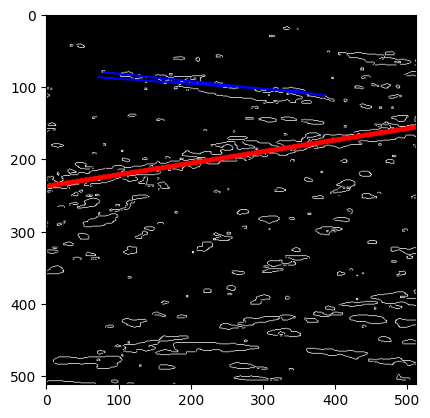

In [201]:
filtered_lines = filter_lines_by_angle(filtered_lines, 2, 6)

# show the filtered lines on a copy of the original image
aponeuroses_filtered = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
# aponeuroses_filtered = cv2.cvtColor(aponeuroses_filtered, cv2.COLOR_GRAY2BGR)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(aponeuroses_filtered, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(aponeuroses_filtered, cmap='gray')

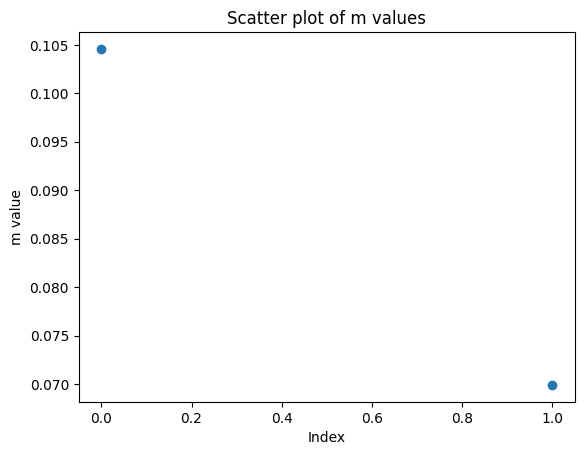

In [202]:
m_values, c_values = calculate_slope_intercept(filtered_lines)
plot_c_values(m_values)

In [204]:
intercept = np.median(c_values)
slope = np.median(m_values)
intercept, slope

(76.79951094656977, 0.08725261666438137)

In [205]:
new_slope = slope_to_angle(slope)
int(new_slope)

4

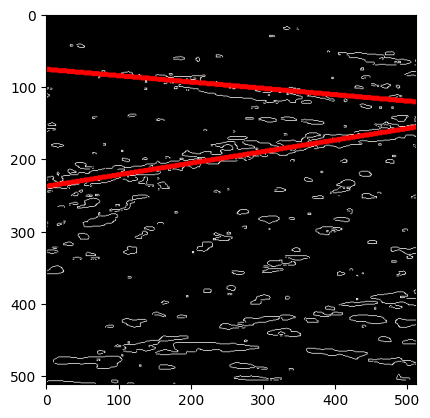

In [207]:
# Draw a line with the calculated slope and intercept on a copy of the original image
aponeuroses_line = aponeuroses_line.copy().astype('uint8')
# aponeuroses_line = aponeuroses_line.copy().astype('uint8')
# Convert to 3 channels
# aponeuroses_line = cv2.cvtColor(aponeuroses_line, cv2.COLOR_GRAY2BGR)
width = aponeuroses_line.shape[1]

# Draw the line
x1 = 0
y1 = int(intercept)
x2 = width
y2 = int(slope * x2 + intercept)

# Draw two more lines to better visualize the aponeuroses
x3 = 0
y3 = int(intercept - 1)
x4 = width
y4 = int(slope * x4 + intercept - 1)

x5 = 0
y5 = int(intercept + 1)
x6 = width
y6 = int(slope * x6 + intercept + 1)

cv2.line(aponeuroses_line, (x1, y1), (x2, y2), (255, 0, 0), 5)
# cv2.line(aponeuroses_line, (x3, y3), (x4, y4), (255, 0, 0), 2)
# cv2.line(aponeuroses_line, (x5, y5), (x6, y6), (255, 0, 0), 2)

plt.imshow(aponeuroses_line, cmap='gray')

### Pipeline

In [11]:
# Get all files in data_path
def get_files(data_path):
    # [os.path.join(data_path,f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.png')]
    all_files = []
    for f in os.listdir(data_path):
        if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.png'):
            all_files.append(os.path.join(data_path, f))

    # # Get 10 equispaced files
    file_indexes = np.linspace(0, len(all_files)-1, 10, dtype=int)
    selected_files = [all_files[i] for i in file_indexes]
    return selected_files

In [12]:
# Get all files
data_path = 'YOUR DATA PATH'
folders = get_folders(data_path)
files = []
for folder in folders:
    subfolders = get_subfolders(folder)
    for subfolder in subfolders:
        files.extend(get_files(subfolder))

len(files)

440

In [13]:
# Get the 4 coordinates of the quadrilateral
def get_quadrilateral_coordinates(line_d, line_s, width):
    # Line is represented as (slope, intercept)
    
    slope_d, intercept_d = line_d
    slope_s, intercept_s = line_s

    # if nonetype return []
    if slope_d is None or intercept_d is None or slope_s is None or intercept_s is None:
        return []

    # Get the 4 points of the quadrilateral
    x1 = 0
    y1 = int(intercept_d)
    x2 = width
    y2 = int(slope_d * x2 + intercept_d)
    x3 = 0
    y3 = int(intercept_s)
    x4 = width
    y4 = int(slope_s * x4 + intercept_s)
    return [[x3, y3],[x4, y4], [x2, y2], [x1, y1]]

In [29]:
def extract_coordinates(model, file_path, method, threshold, flip=False):
    print(file_path)
    image = load_image(file_path)
    predictions = model(image, training=False)
    frame = predictions[0, ..., 0].numpy()
    if flip:
        frame = cv2.flip(frame, 1)

    frame = isolate_intensity(frame, method)

    frame_clipped = np.clip(frame, 0, 1)
    frame_scaled = (frame_clipped * 255).astype(np.uint8)

    edges = edge_detection(frame_scaled)

    _, deep_aponeurosis, superficial_aponeurosis = hough_transform(edges, threshold=threshold)

    if superficial_aponeurosis is None:
        if deep_aponeurosis is None:
            return []
        else:
            # set deep_aponeurosis to a straight line along the x-axis
            superficial_aponeurosis = [0, 0]
    if deep_aponeurosis is None:
        return []

    coordinates = get_quadrilateral_coordinates(deep_aponeurosis, superficial_aponeurosis, frame_scaled.shape[1])

    coordinates = [[max(0, x), max(0, y)] for x, y in coordinates]
    return coordinates

In [16]:
model = tf.keras.models.load_model('./saved_model_1')

2024-04-10 14:09:23.038778: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-10 14:09:23.038837: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-10 14:09:23.038841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-10 14:09:23.038912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 14:09:23.038953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
extract_coordinates(model, files[0], 'avg_min_intensity', 20, flip=True)

/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/348.png


[[0, 86], [512, 86], [512, 204], [0, 284]]

In [25]:
import pandas as pd
def generate_csv(model, data_path, csv_file_name):
    columns = ['Filename', 'Technique', 'Method', 'Threshold', 'Frame1', 'Frame2', 'Frame3', 'Frame4', 'Frame5', 'Frame6', 'Frame7', 'Frame8', 'Frame9', 'Frame10']
    if not os.path.exists(csv_file_name):
        pd.DataFrame(columns=columns).to_csv(csv_file_name, index=False)
    folders = get_folders(data_path)
    subfolders = []
    for folder in folders:
        subfolders += get_subfolders(folder)
    for subfolder in subfolders:
        files = get_files(subfolder)
        technique = 'N2N_ZS'
        # Go through all 10 files
        for threshold in range(10, 101, 10):
            for method in ['q1', 'avg_min_intensity']:
                frame_data = {'filename': subfolder, 'technique': technique, 'method': method, 'threshold': threshold}
                for i, file in enumerate(files):
                    print(f'Processing frame {i+1}')
                    print(file)
                    coordinates = extract_coordinates(model, file, method, threshold, flip=True)
                    frame_data[f'Frame{i+1}'] = coordinates
                # Append the data for this technique and method to the CSV
                pd.DataFrame([frame_data]).to_csv(csv_file_name, mode='a', header=False, index=False)
            

In [241]:
type(model)

__main__.SimpleImageToImageModel

In [30]:
generate_csv(model, data_path, 'N2N_ZS_thresh.csv')

Processing frame 1
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/348.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/348.png
Processing frame 2
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/1147.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/1147.png
Processing frame 3
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/199.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/199.png
Processing frame 4
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/275.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/275.png
Processing frame 5
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/1057.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/1057.png
Processing frame 6
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0/686.png
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW1

### Evaluate

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import json

import re
import ast

In [32]:
def sort_points_clockwise(points):
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    
    # Calculate the angles of each point with respect to the centroid
    def angle_with_centroid(point):
        delta = point - centroid
        return np.arctan2(delta[1], delta[0])
    
    # Sort the points by the angles
    sorted_points = sorted(points, key=angle_with_centroid)
    
    return np.array(sorted_points)

In [42]:
def read_roi(file_name, filepath, frame_num):
    df = pd.read_csv(filepath)
    # file_name = file_name.split('/')[-1]
    file_name = file_name.split('.')[0]
    row = df.loc[df['Filename'] == file_name.split('.')[0]]
    pts = np.asarray((json.loads(row[f'Frame{frame_num}'].values[0])))

    pts = sort_points_clockwise(pts)

    return pts

def read_extracted(file_name, file_path, frame_num, technique, method, threshold):
    extracted_df = pd.read_csv(file_path)
    extracted_df['Filename'] = extracted_df['Filename'].apply(lambda x: x.split('.')[0])
    extracted_df = extracted_df[extracted_df['Filename'] == file_name.split('.')[0]]
    extracted_df = extracted_df[(extracted_df['Technique'] == technique) & (extracted_df['Method'] == method) & (extracted_df['Threshold'] == threshold)]
    
    array_str = extracted_df[f'Frame{frame_num}'].values[0]
    
    try:
        list_from_str = ast.literal_eval(array_str)
    except ValueError as e:
        print(array_str)
        print(f"Error converting string to list: {e}")
    
    extracted_roi = np.array(list_from_str)
    
    return extracted_roi

In [34]:
from shapely.geometry import Polygon
from shapely.validation import make_valid   

def calculate_IoU(roi, extracted):
    poly1 = Polygon(roi)
    poly2 = Polygon(extracted)

    poly1 = make_valid(poly1)
    poly2 = make_valid(poly2)

    # Calculate intersection and union areas
    try:
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
    except Exception as e:
        print(f"Error processing intersection or union: {e}")
        print(f"poly1: {poly1}")
        print(f"poly2: {poly2}")


    # Calculate IoU
    iou = intersection_area / union_area

    return iou, intersection_area, union_area

In [40]:
# Calculate IoU for all frames (1 to 10) and techniques and methods for a given file and save the results in a dataframe

def calculate_IoU_all_frames(file_name, roi_file_path, extracted_file_path):
    iou_df = pd.DataFrame(columns=['Filename','Frame', 'Technique', 'Method', 'Threshold', 'IoU', 'Intersection Area', 'Union Area'])
    rois = []
    for frame in range(1, 11):
        roi = read_roi(file_name, roi_file_path, frame)
        rois.append(roi)
    rois = sorted(rois, key=lambda x: Polygon(x).area)
    rois = np.array(rois)
    roi_median = rois[len(rois)//2]


    technique = 'N2N_ZS'
    for threshold in range(10, 101, 10):
        for method in ['q1', 'avg_min_intensity']:
            extracts = []
            for frame in range(1, 11):
                print(file_name, extracted_file_path, frame, technique, method, threshold)
                extracted = read_extracted(file_name, extracted_file_path, frame, technique, method, threshold)
                if len(extracted) == 0:
                    continue
                # if len(extracted) > 0:
                extracts.append(extracted)

            if len(extracts) > 0:
                extracts.sort(key=lambda x: Polygon(x).area)
                extracts = np.array(extracts)
                if len(extracts) == 0:
                    continue
                extracted_q3 = np.percentile(extracts,50, axis=0)
                roi_median = Polygon(roi_median).buffer(0)
                extracted_q3 = Polygon(extracted_q3).buffer(0)
                # print(extracted_q3)
                iou, intersection_area, union_area = calculate_IoU(roi_median, extracted_q3)
                iou_df.loc[len(iou_df)] = [file_name, frame, technique, method, threshold, iou, intersection_area, union_area]
    return iou_df

In [38]:
read_extracted('/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0', 'N2N_ZS_thresh.csv', 1, 'N2N_ZS', 'avg_min_intensity', 10)

array([[  0,  40],
       [512,  14],
       [512, 104],
       [  0, 221]])

In [43]:
calculate_IoU_all_frames('/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0', 'roi_data-png.csv', 'N2N_ZS_thresh.csv')

/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 1 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 2 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 3 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 4 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 5 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 6 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 7 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 8 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 9 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 10 N2N_ZS q1 10

Filename  Frame Technique  \
0   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
1   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
2   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
3   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
4   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
5   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
6   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
7   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
8   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
9   /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
10  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
11  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
12  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
13  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
14  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
15  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
16  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
17  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
18  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
19  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   

               Method  Threshold       IoU  Intersection Area     Union Area  
0                  q1         10  0.829722       97274.302588  117237.197412  
1   avg_min_intensity         10  0.693223       85202.979507  122908.520493  
2                  q1         20  0.859953      100718.508531  117120.991469  
3   avg_min_intensity         20  0.872116      102135.349145  117112.150855  
4                  q1         30  0.702400       86974.569700  123824.930300  
5   avg_min_intensity         30  0.502904       62185.904962  123653.595038  
6                  q1         40  0.734339       90664.015034  123463.484966  
7   avg_min_intensity         40  0.505499       61668.370199  121995.129801  
8                  q1         50  0.883910      103529.129985  117126.370015  
9   avg_min_intensity         50  0.566335       74505.762390  131557.737610  
10                 q1         60  0.894746      104863.902981  117199.597019  
11  avg_min_intensity         60  0.530226       66877.468827  126130.031173  
12                 q1         70  0.807686      100077.317297  123906.182703  
13  avg_min_intensity         70  0.776796      105421.864703  135713.635297  
14                 q1         80  0.454479       58348.970659  128386.529341  
15  avg_min_intensity         80  0.743800      106948.664160  143786.835840  
16                 q1         90  0.173336       23653.155517  136458.344483  
17  avg_min_intensity         90  0.600363       77687.179366  129400.320634  
18                 q1        100  0.085165       11963.023632  140468.476368  
19  avg_min_intensity        100  0.607275       87480.843037  144054.656963

In [44]:
# Append dataframe to existing csv file
def append_to_csv(df, file_path):
    with open(file_path, 'a') as f:
        df.to_csv(f, header=f.tell()==0, index=False)

In [45]:
file_names = []
for folder in get_folders(data_path):
    file_names += get_subfolders(folder)

set(list(file_names))

{'/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW112/WW112_100_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW112/WW112_125_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW112/WW112_125_GP10',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW112/WW112_150_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW112/WW112_175_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW128/WW128_100_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW128/WW128_125_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW128/WW128_125_GP10',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW128/WW128_150_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW128/WW128_175_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_100_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_GP10',
 '/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_150_G0',


In [354]:
data_dir_path = "/Users/aarjavjain/Desktop/Education/Y4/PRJ/fascicle-segmentation/data/"
# All files in the data directory with the .mat extension
files = [os.path.join(data_dir_path, f) for f in os.listdir(data_dir_path) if f.endswith('.mat')]

In [46]:
for file_name in file_names:
    print(f"Processing {file_name}")
    append_to_csv(calculate_IoU_all_frames(file_name, 'roi_data-png.csv', 'N2N_ZS_thresh.csv'), 'N2N_ZS_thresh_IoU.csv')

Processing /Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 1 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 2 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 3 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 4 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 5 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 6 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 7 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 8 N2N_ZS q1 10
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW141/WW114_125_G0 N2N_ZS_thresh.csv 9 N2N_ZS q1 10
/Users/aarjavjain/Desk

In [47]:
# Read iou_results.csv
iou_file_name = 'N2N_ZS_thresh_IoU.csv'
iou_results = pd.read_csv(iou_file_name)

In [48]:
# Number of duplicate rows in iou_results dataframe 
duplicate_rows = iou_results[iou_results.duplicated()]
duplicate_rows

Empty DataFrame
Columns: [Filename, Frame, Technique, Method, Threshold, IoU, Intersection Area, Union Area]
Index: []

In [ ]:
# # Remove duplicate rows from iou_results dataframe
iou_results = iou_results.drop_duplicates()
iou_results.to_csv(iou_file_name, index=False)

In [49]:
# For each technique, count how many times it appears in the iou_results dataframe
def count_technique_appearances(iou_results):
    technique_count_df = pd.DataFrame(columns=['Technique', 'Count'])
    technique = 'N2N_ZS'
    count = iou_results[iou_results['Technique'] == technique].shape[0]
    technique_count_df.loc[len(technique_count_df)] = [technique, count]
    return technique_count_df

In [50]:
count_technique_appearances(iou_results)

Technique  Count
0    N2N_ZS    880

In [54]:
# For each technique and method, calculate the average IoU across all frames and save the results in new dataframe
def calculate_average_iou(iou_results):
    technique = 'N2N_ZS'
    avg_iou_df = pd.DataFrame(columns=['Technique', 'Method', 'Threshold', 'Average IoU'])
    for threshold in range(10, 101, 10):
        for method in ['q1', 'avg_min_intensity']:
            avg_iou = iou_results[(iou_results['Technique'] == technique) & (iou_results['Method'] == method) & (iou_results['Threshold'] == threshold)]['IoU'].mean()
            avg_iou_df.loc[len(avg_iou_df)] = [technique, method, threshold, avg_iou]
    return avg_iou_df

In [55]:
avg_iou = calculate_average_iou(iou_results)
avg_iou.sort_values(by='Average IoU', ascending=False)

Technique             Method  Threshold  Average IoU
2     N2N_ZS                 q1         20     0.724494
4     N2N_ZS                 q1         30     0.717064
8     N2N_ZS                 q1         50     0.715722
17    N2N_ZS  avg_min_intensity         90     0.715168
19    N2N_ZS  avg_min_intensity        100     0.714693
6     N2N_ZS                 q1         40     0.704877
0     N2N_ZS                 q1         10     0.696471
15    N2N_ZS  avg_min_intensity         80     0.688416
10    N2N_ZS                 q1         60     0.684571
13    N2N_ZS  avg_min_intensity         70     0.683533
11    N2N_ZS  avg_min_intensity         60     0.670459
3     N2N_ZS  avg_min_intensity         20     0.662288
5     N2N_ZS  avg_min_intensity         30     0.652210
7     N2N_ZS  avg_min_intensity         40     0.646254
9     N2N_ZS  avg_min_intensity         50     0.642983
12    N2N_ZS                 q1         70     0.639399
14    N2N_ZS                 q1         80     0.635794
1     N2N_ZS  avg_min_intensity         10     0.609983
16    N2N_ZS                 q1         90     0.548522
18    N2N_ZS                 q1        100     0.505122

In [61]:
iou_results.sort_values(by='IoU', ascending=False)[(iou_results['Threshold'] == 20)]

/var/folders/4_/jh94ys7j1sddtwdj3kv9kvvm0000gn/T/ipykernel_33623/4240831421.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  iou_results.sort_values(by='IoU', ascending=False)[(iou_results['Threshold'] == 20)]


Filename  Frame Technique  \
723  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
743  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
243  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
203  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
683  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
..                                                 ...    ...       ...   
663  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
643  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
623  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
123  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
603  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   

                Method  Threshold       IoU  Intersection Area     Union Area  
723  avg_min_intensity         20  0.966313      143971.505371  148990.494629  
743  avg_min_intensity         20  0.957622      132533.733204  138398.766796  
243  avg_min_intensity         20  0.937497      112973.519423  120505.480577  
203  avg_min_intensity         20  0.927182      116603.160626  125760.839374  
683  avg_min_intensity         20  0.918872      129555.492220  140994.007780  
..                 ...        ...       ...                ...            ...  
663  avg_min_intensity         20  0.402039       61846.211467  153831.288533  
643  avg_min_intensity         20  0.386384       57343.742731  148411.257269  
623  avg_min_intensity         20  0.381675       53183.520604  139342.479396  
123  avg_min_intensity         20  0.347539       40339.147387  116070.852613  
603  avg_min_intensity         20  0.338693       48192.878083  142290.621917  

[88 rows x 8 columns]

In [109]:
# Find the files with the highest IoU, lowest IoU, and the median IoU
def find_extreme_iou_files(iou_results):
    # Sort the dataframe by IoU
    iou_results = iou_results.sort_values(by='IoU', ascending=False)
    # Get the file names with the highest, lowest, and median IoU
    max_iou = iou_results.iloc[0]
    min_iou = iou_results.iloc[-1]
    median_iou = iou_results.iloc[len(iou_results) // 2]
    return max_iou, min_iou, median_iou

max_iou, min_iou, median_iou = find_extreme_iou_files(iou_results)

In [175]:
# Find all rows with an IoU between 0.70 and 0.73
iou_results = iou_results.sort_values(by='IoU', ascending=False)
avg_iou_rows = iou_results[(iou_results['IoU'] >= 0.55) & (iou_results['IoU'] <= 0.60) & (iou_results['Threshold'] == 20)]
# List of filenames
# avg_iou_rows['Filename'].unique()

In [184]:
avg_iou_rows = iou_results[(iou_results['Filename'] == 'YOUR SUBFOLDER PATH (THIS IS THE NAME OF THE FILE TYPE)') & (iou_results['Threshold'] == 20)]
avg_iou_rows

Filename  Frame Technique  \
723  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
722  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   

                Method  Threshold       IoU  Intersection Area     Union Area  
723  avg_min_intensity         20  0.966313      143971.505371  148990.494629  
722                 q1         20  0.716113      104783.444336  146322.555664

In [196]:
avg_iou_rows = iou_results[(iou_results['Filename'] == 'YOUR SUBFOLDER PATH (THIS IS THE NAME OF THE FILE TYPE)') & (iou_results['Threshold'] == 20)]
avg_iou_rows

Filename  Frame Technique  \
463  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   
462  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...     10    N2N_ZS   

                Method  Threshold       IoU  Intersection Area     Union Area  
463  avg_min_intensity         20  0.580615       99544.808598  171447.191402  
462                 q1         20  0.564002       96662.032322  171385.967678

/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW196/WW196_125_GP10
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 10, 8, 9, 6, 7, 3, 4, 2, 5]
Frame numbers: 7 
Frames: POLYGON ((0 89, 0 310.5, 512 256, 512 97, 0 89))
Number of files in folder: 1250
[   1  139  278  417  556  694  833  972 1111 1250]
/Users/aarjavjain/Desktop/Education/Y4/PRJ/data/WW196/WW196_125_GP10/833.png


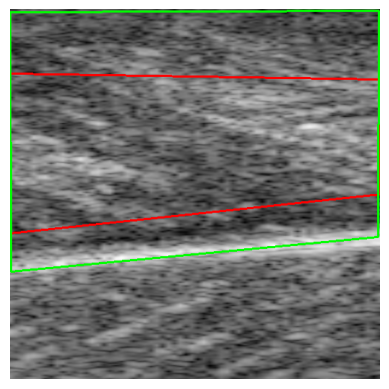

In [198]:
predictions = pd.read_csv('N2N_ZS_thresh.csv')
# Find the row in predictions that corresponds to the first row in avg
row = avg_iou_rows.iloc[0]
file_name = row['Filename']

# Find the row in predictions that corresponds to the first row in avg
pred = predictions[(predictions['Filename'] == file_name) & (predictions['Technique'] == 'N2N_ZS') & (predictions['Method'] == 'q1') & (predictions['Threshold'] == 20)]
print(file_name)
pred_frames = []
pred_frame_nums = []
for i in range(1, 11):
    pred_frame = ast.literal_eval(pred[f'Frame{i}'].values[0])
    frame_num = i
    pred_frames.append(pred_frame)
    pred_frame_nums.append(frame_num)
print(pred_frame_nums)

# When sorting pred_frames, sort pred_frame_nums as well in the same order
pred_frames = sorted(pred_frames, key=lambda x: Polygon(x).area)
pred_frame_nums = [x for _, x in sorted(zip(pred_frames, pred_frame_nums), key=lambda pair: pair[0])]
print(pred_frame_nums)
pred_frames = np.array(pred_frames)
pred_frames = np.percentile(pred_frames, 50, axis=0)
pred_frame_nums = pred_frame_nums[len(pred_frame_nums) // 2]
pred_frames = Polygon(pred_frames).buffer(0)
print(f'Frame numbers: {pred_frame_nums} \nFrames: {pred_frames}')

# Get number of files in file_name folder
def get_num_files(file_name):
    file_name = file_name.split('.')[0]
    num_files = len([f for f in os.listdir(file_name) if f.endswith('.png')])
    return num_files

# Get the number of files in the folder
num_files = get_num_files(file_name)
print(f'Number of files in folder: {num_files}')

# From 1 to num_files, find 10 equispaced numbers
file_indexes = np.linspace(1, num_files, 10, dtype=int)
print(file_indexes)
file_index = file_indexes[pred_frame_nums-1]

true_frames = []
for i in range(1, 11):
    true_frame = read_roi(file_name, 'roi_data-png.csv', i)
    true_frames.append(true_frame)

true_frames = np.array(true_frames)
true_frames = sorted(true_frames, key=lambda x: Polygon(x).area)
true_frames = np.array(true_frames)
true_frames = np.percentile(true_frames, 50, axis=0)
true_frames = Polygon(true_frames).buffer(0)

# Draw the predicted and true polygons on the image
image = cv2.imread(file_name + f'/{file_index}.png')
image = cv2.flip(image, 1)
print(file_name + f'/{file_index}.png')

# Draw the predicted polygon in red
pred_coords = np.array(pred_frames.exterior.coords)
pred_coords = pred_coords.astype(int)
image = cv2.polylines(image, [pred_coords], isClosed=True, color=(255, 0, 0), thickness=2)

# Draw the true polygon in green
true_coords = np.array(true_frames.exterior.coords)
true_coords = true_coords.astype(int)
image = cv2.polylines(image, [true_coords], isClosed=True, color=(0, 255, 0), thickness=2)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
predictions = pd.read_csv('N2N_ZS_thresh.csv')
# Only find rows where threshold is 20
max_iou_row = predictions[(predictions['Filename'] == max_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]
min_iou_row = predictions[(predictions['Filename'] == min_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]
median_iou_row = predictions[(predictions['Filename'] == median_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]


In [110]:
max_iou, min_iou, median_iou

(Filename             /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...
 Frame                                                               10
 Technique                                                       N2N_ZS
 Method                                               avg_min_intensity
 Threshold                                                           70
 IoU                                                           0.989764
 Intersection Area                                        145154.410271
 Union Area                                               146655.589729
 Name: 733, dtype: object,
 Filename             /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...
 Frame                                                               10
 Technique                                                       N2N_ZS
 Method                                               avg_min_intensity
 Threshold                                                          100
 IoU                                 

In [91]:
predictions = pd.read_csv('N2N_ZS_thresh.csv')
# Only find rows where threshold is 20
max_iou_row = predictions[(predictions['Filename'] == max_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]
min_iou_row = predictions[(predictions['Filename'] == min_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]
median_iou_row = predictions[(predictions['Filename'] == median_iou) & (predictions['Threshold'] == 20) & (predictions['Method'] == 'avg_min_intensity')]


In [100]:
max_iou_row
# Sort the frames in max_iou_row by area
max_pred_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(max_iou_row[f'Frame{i}'].values[0])
    max_pred_frames.append(frame)
max_pred_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
max_pred_coord = max_pred_frames[len(max_pred_frames) // 2]

# Sort the frames in min_iou_row by area
min_pred_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(min_iou_row[f'Frame{i}'].values[0])
    min_pred_frames.append(frame)
min_pred_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
min_pred_coord = min_pred_frames[len(min_pred_frames) // 2]

# Sort the frames in median_iou_row by area
median_pred_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(median_iou_row[f'Frame{i}'].values[0])
    median_pred_frames.append(frame)
median_pred_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
median_pred_coord = median_pred_frames[len(median_pred_frames) // 2]


In [98]:
truths = pd.read_csv('roi_data-png.csv')
max_iou_truth = truths[truths['Filename'] == max_iou]
min_iou_truth = truths[truths['Filename'] == min_iou]
median_iou_truth = truths[truths['Filename'] == median_iou]


In [101]:
max_truth_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(max_iou_truth[f'Frame{i}'].values[0])
    max_truth_frames.append(frame)
max_truth_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
max_truth_coord = max_truth_frames[len(max_truth_frames) // 2]

min_truth_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(min_iou_truth[f'Frame{i}'].values[0])
    min_truth_frames.append(frame)
min_truth_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
min_truth_coord = min_truth_frames[len(min_truth_frames) // 2]

median_truth_frames = []
for i in range(1, 11):
    frame = ast.literal_eval(median_iou_truth[f'Frame{i}'].values[0])
    median_truth_frames.append(frame)
median_truth_frames.sort(key=lambda x: Polygon(x).area)
# Get the median frame
median_truth_coord = median_truth_frames[len(median_truth_frames) // 2]

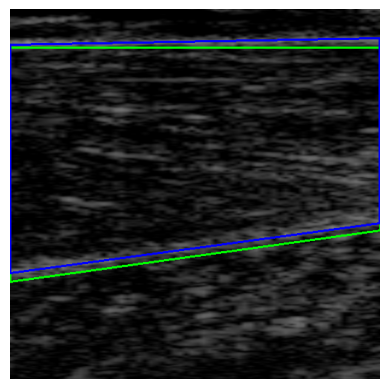

In [106]:
# cv2 load image at max_iou path and display
max_iou_path = max_iou + '/1.png'
max_iou_image = cv2.imread(max_iou_path)
max_iou_image = cv2.flip(max_iou_image, 1)

# Draw the predicted aponeurosis
max_iou_image = cv2.polylines(max_iou_image, [np.array(max_pred_coord).astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)

# Draw the true aponeurosis
max_iou_image = cv2.polylines(max_iou_image, [np.array(max_truth_coord).astype(int)], isClosed=True, color=(0, 0, 255), thickness=2)

plt.imshow(max_iou_image)
plt.axis('off')
plt.show()



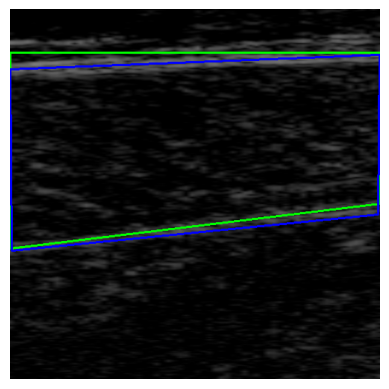

In [107]:
# cv2 load image at min_iou path and display
min_iou_path = min_iou + '/1.png'
min_iou_image = cv2.imread(min_iou_path)
min_iou_image = cv2.flip(min_iou_image, 1)

# Draw the predicted aponeurosis
min_iou_image = cv2.polylines(min_iou_image, [np.array(min_pred_coord).astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)

# Draw the true aponeurosis
min_iou_image = cv2.polylines(min_iou_image, [np.array(min_truth_coord).astype(int)], isClosed=True, color=(0, 0, 255), thickness=2)

plt.imshow(min_iou_image)
plt.axis('off')
plt.show()


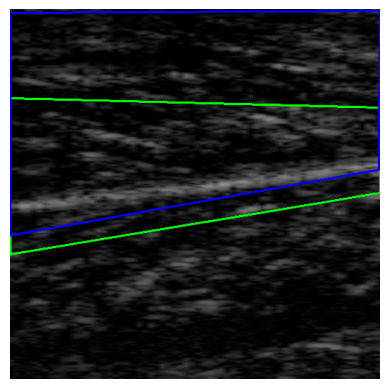

In [108]:
# cv2 load image at median_iou path and display
median_iou_path = median_iou + '/1.png'
median_iou_image = cv2.imread(median_iou_path)
median_iou_image = cv2.flip(median_iou_image, 1)

# Draw the predicted aponeurosis
median_iou_image = cv2.polylines(median_iou_image, [np.array(median_pred_coord).astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)

# Draw the true aponeurosis
median_iou_image = cv2.polylines(median_iou_image, [np.array(median_truth_coord).astype(int)], isClosed=True, color=(0, 0, 255), thickness=2)

plt.imshow(median_iou_image)
plt.axis('off')
plt.show()

In [94]:
min_iou_row

Filename Technique  \
203  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...    N2N_ZS   

                Method  Threshold                                      Frame1  \
203  avg_min_intensity         20  [[0, 60], [512, 60], [512, 269], [0, 331]]   

                                         Frame2  \
203  [[0, 64], [512, 64], [512, 274], [0, 364]]   

                                           Frame3  \
203  [[0, 127], [512, 127], [512, 228], [0, 291]]   

                                         Frame4  \
203  [[0, 78], [512, 62], [512, 266], [0, 328]]   

                                         Frame5  \
203  [[0, 54], [512, 54], [512, 279], [0, 341]]   

                                         Frame6  \
203  [[0, 67], [512, 60], [512, 277], [0, 331]]   

                                         Frame7  \
203  [[0, 71], [512, 71], [512, 277], [0, 339]]   

                                         Frame8  \
203  [[0, 64], [512, 60], [512, 274], [0, 346]]   

                                         Frame9  \
203  [[0, 21], [512, 17], [512, 188], [0, 251]]   

                                        Frame10  
203  [[0, 98], [512, 81], [512, 272], [0, 326]]

In [95]:
median_iou_row

Filename Technique  \
823  /Users/aarjavjain/Desktop/Education/Y4/PRJ/dat...    N2N_ZS   

                Method  Threshold  \
823  avg_min_intensity         20   

                                           Frame1  \
823  [[0, 130], [512, 130], [512, 205], [0, 285]]   

                                          Frame2  \
823  [[0, 101], [512, 93], [512, 217], [0, 290]]   

                                         Frame3  \
823  [[0, 65], [512, 78], [512, 222], [0, 304]]   

                                          Frame4  \
823  [[0, 120], [512, 93], [512, 230], [0, 284]]   

                                         Frame5  \
823  [[0, 82], [512, 82], [512, 277], [0, 350]]   

                                           Frame6  \
823  [[0, 123], [512, 136], [512, 254], [0, 339]]   

                                           Frame7  \
823  [[0, 145], [512, 173], [512, 223], [0, 304]]   

                                          Frame8  \
823  [[0, 104], [512, 95], [512, 257], [0, 329]]   

                                          Frame9  \
823  [[0, 103], [512, 76], [512, 215], [0, 269]]   

                                        Frame10  
823  [[0, 93], [512, 93], [512, 240], [0, 376]]